# Starbucks Rewards: Predicting Consumer Responses

The project is an experiment that determines how do we take this experimental data and discover what are the offers that excite people? So, it’s about discovering what is the most valuable offer there is, not just for the customers as a whole but at an individual personal level. 

Starbucks rewards mobile app customers are simulated with this simulated data. An offer could be an advertisement for a drink, a discount, or a buy one get one free deal. Some customers may not be sent offers during certain days or weeks and not all customers will receive the same offer. That is the challenge to solve using this dataset, who gets what offer? 

In [ ]:
# TODO: Install any packages that you might need

In [1]:
# TODO: Import any packages that you might need
from collections import defaultdict
import pandas as pd
import numpy as np

## Data Preparation

### Dataset details

portfolio.json
* id (string) - offer id
* offer_type (string) - a type of offer ie BOGO, discount, informational
* difficulty (int) - the minimum required to spend to complete an offer
* reward (int) - the reward is given for completing an offer
* duration (int) - time for the offer to be open, in days
* channels (list of strings)

profile.json
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

transcript.json
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since the start of the test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



## Overview


In [2]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'became_member_on'}>],
       [<AxesSubplot:title={'center':'income'}>, <AxesSubplot:>]],
      dtype=object)

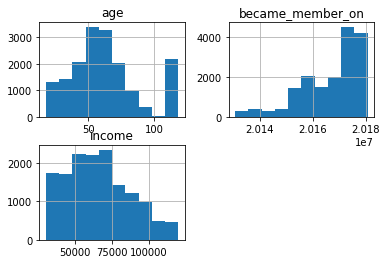

In [3]:
profile.hist()

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

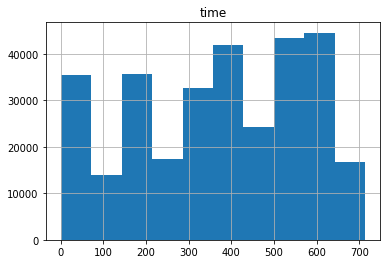

In [4]:
transcript.hist()

## Class details

In [5]:
# There are 9 classes below.
print(portfolio.to_string())

   reward                      channels  difficulty  duration     offer_type                                id
0      10       [email, mobile, social]          10         7           bogo  ae264e3637204a6fb9bb56bc8210ddfd
1      10  [web, email, mobile, social]          10         5           bogo  4d5c57ea9a6940dd891ad53e9dbe8da0
2       0          [web, email, mobile]           0         4  informational  3f207df678b143eea3cee63160fa8bed
3       5          [web, email, mobile]           5         7           bogo  9b98b8c7a33c4b65b9aebfe6a799e6d9
4       5                  [web, email]          20        10       discount  0b1e1539f2cc45b7b9fa7c272da2e1d7
5       3  [web, email, mobile, social]           7         7       discount  2298d6c36e964ae4a3e7e9706d1fb8c2
6       2  [web, email, mobile, social]          10        10       discount  fafdcd668e3743c1bb461111dcafc2a4
7       0       [email, mobile, social]           0         3  informational  5a8bc65990b245e5a138643cd4eb9837
8

## Class distributions of offers recieved, offers viewed, and offers completed

In [6]:
outcomes = ["offer received", "offer viewed", "offer completed"]
offers = [transcript[transcript['event']== offer] for offer in outcomes]

In [7]:
def view(offers):
    offer_count = defaultdict(int)
    for offer in offers.value:
        val = offer['offer id'] if 'offer id' in offer else offer['offer_id']
        if val in offer_count:
            offer_count[val]+=1
        else:
            offer_count[val] = 1

    return offer_count

counts = [view(offer) for offer in offers]

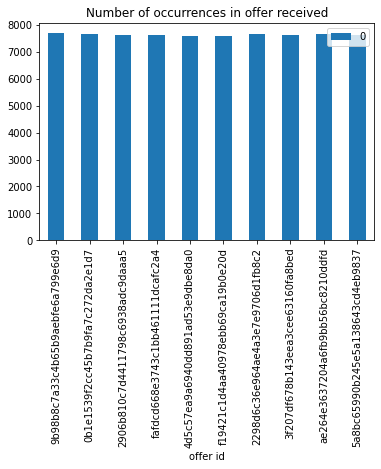

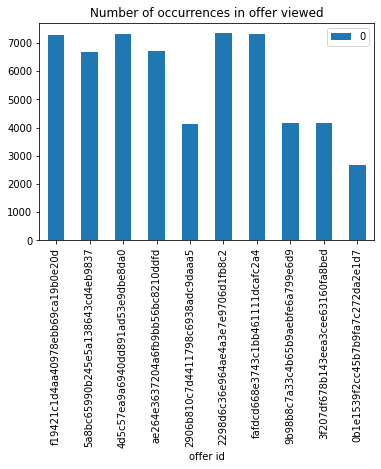

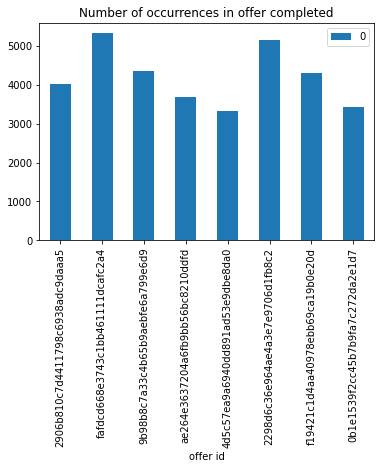

In [8]:
def check_data(offer_count, name):
    data = pd.DataFrame.from_dict(offer_count, orient='index')
    bar_plot = data.plot.bar(title="Number of occurrences in " + name)
    bar_plot.set_xlabel("offer id")

for count, name in zip(counts, outcomes):
    check_data(count, name)

## Data Cleaning and Preprocessing

We will handle missing values in the <strong>genders</strong> column in the `profile.json` data set by assigning an unique category. 

pros:
Less possibilities with one extra category, resulting in low variance after one hot encoding — since it is categorical.
Negates the loss of data by adding an unique category

cons:
Adds less variance
Adds another feature to the model while encoding, which may result in poor performance

In [9]:
profile["gender"].fillna('U', inplace=True)
profile.head()

,gender,age,id,became_member_on,income
0,U,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,U,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,U,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [12]:
new_transcript = transcript[transcript['event'].str.startswith('o')]
new_transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [13]:
# Split / Explode a column of dictionaries into separate columns
new_transcript = pd.concat([new_transcript.drop(['value'], axis=1), new_transcript['value'].apply(pd.Series)], axis=1)

In [14]:
to_drop = ['offer id',
           'event',
           'id',
           'reward']

new_transcript = new_transcript.dropna(subset = ["offer_id"]).rename(columns={"person": "id"})
data = pd.merge(new_transcript, profile, on="id")
data['became_member_on'] = pd.to_datetime(data['became_member_on'],format='%Y%m%d')
data.drop(to_drop, inplace=True, axis=1)

data.head()

,time,offer_id,gender,age,became_member_on,income
0,0,2906b810c7d4411798c6938adc9daaa5,M,42,2016-01-17,96000.0
1,354,2298d6c36e964ae4a3e7e9706d1fb8c2,M,42,2016-01-17,96000.0
2,474,0b1e1539f2cc45b7b9fa7c272da2e1d7,M,42,2016-01-17,96000.0
3,540,4d5c57ea9a6940dd891ad53e9dbe8da0,M,42,2016-01-17,96000.0
4,0,fafdcd668e3743c1bb461111dcafc2a4,F,39,2017-12-17,67000.0


Also, we will handle missing values in the <strong>income</strong> column in the `data` variable by replacing with mean. 

Pros:
This is a better approach when the data size is small
It can prevent data loss which results in removal of the rows and columns

Cons:
Inputing the approximations add variance and bias
Works poorly compared to other multiple-imputations method

In [16]:
mean_val = data["income"].mean()
data["income"].replace(np.NaN, mean_val, inplace=True)
print(data)

       time                          offer_id gender  age became_member_on  \
0         0  2906b810c7d4411798c6938adc9daaa5      M   42       2016-01-17   
1       354  2298d6c36e964ae4a3e7e9706d1fb8c2      M   42       2016-01-17   
2       474  0b1e1539f2cc45b7b9fa7c272da2e1d7      M   42       2016-01-17   
3       540  4d5c57ea9a6940dd891ad53e9dbe8da0      M   42       2016-01-17   
4         0  fafdcd668e3743c1bb461111dcafc2a4      F   39       2017-12-17   
...     ...                               ...    ...  ...              ...   
33574   714  fafdcd668e3743c1bb461111dcafc2a4      M   28       2017-10-16   
33575   714  2298d6c36e964ae4a3e7e9706d1fb8c2      M   56       2017-10-24   
33576   714  2298d6c36e964ae4a3e7e9706d1fb8c2      U  118       2017-01-16   
33577   714  fafdcd668e3743c1bb461111dcafc2a4      M   39       2018-06-27   
33578   714  fafdcd668e3743c1bb461111dcafc2a4      F   48       2017-12-28   

             income  
0      96000.000000  
1      96000.000000

In [17]:
data.to_csv('data.csv', index = False)

In [ ]:
#TODO: Upload the data to AWS S3

## Model Training
**Note:** You will need to use the `train.py` script to train your model.

In [ ]:
#TODO: Declare your model training hyperparameter.
#NOTE: You can use fixed hyperparameter values here.

In [ ]:
#TODO: Create your training estimator

In [ ]:
# TODO: Fit your estimator

### Hyperparameter Tuning

In [ ]:
#TODO: Create your hyperparameter search space

In [ ]:
#TODO: Create your training estimator

In [ ]:
# TODO: Fit your estimator

In [ ]:
# TODO: Find the best hyperparameters

### Model Deploying and Querying

In [ ]:
# TODO: Deploy your model to an endpoint

In [ ]:
# TODO: Run an prediction on the endpoint

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done